<a href="https://colab.research.google.com/github/Mubashar-Bashir/Langchain_EcoSystem/blob/main/4_trim_filter_messages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Filtering and trimming messages

##Review
Now, we have a deeper understanding of a few things:

<li>How to customize the graph state schema
<li>How to define custom state reducers
<li>How to use multiple graph state schemas
Goals.

##Now, we can start using these concepts with models in LangGraph!

In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai

In [2]:
LANGCHAIN_TRACING_V2="true"
LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"
LANGCHAIN_API_KEY=""
LANGCHAIN_PROJECT="Basic_chatbot_filter_message"

In [11]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] ="Basic_chatbot"

gemini_api_key = userdata.get('Gemini-key')
os.environ["Gemini-key"] = gemini_api_key

#Messages as state
First, let's define some messages.

In [16]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))
#messages.append(SystemMessage(f"write answer in a 5 liners", name="System"))
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


In [61]:

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)

#llm.invoke("greet me")

In [62]:
llm.invoke(messages)

AIMessage(content="Orcas, also known as killer whales, are incredibly widespread and live in all of the world's oceans.  However, they are not uniformly distributed, and different populations (ecotypes) have different ranges and preferences.  Here's a more detailed breakdown:\n\n* **All Oceans:**  As mentioned, they inhabit all oceans, from the frigid Arctic and Antarctic waters to the warmer tropical and temperate seas.\n\n* **Coastal vs. Oceanic:**  Orcas are broadly categorized into two main groups based on their habitat preference:\n\n    * **Resident Orcas:** These orcas tend to live in specific coastal areas, often in relatively stable groups (pods).  They primarily feed on fish, and their ranges are more limited.  Resident populations are found along the coasts of North America (particularly the Pacific Northwest), Norway, and other regions.\n\n    * **Transient Orcas:** These orcas are found in more open ocean habitats and are highly mobile.  They are known for their predatory 

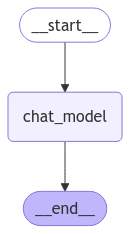

In [19]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph

# Node
def chat_model_node(state: MessagesState) -> MessagesState:
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great you're familiar with whales!  Beyond whales, the world of ocean mammals is incredibly diverse. To suggest further research, let's break it down by group:

**1. Seals, Sea Lions, and Walruses (Pinnipeds):**

* **Seals (Phocidae):**  These lack external ear flaps, have streamlined bodies for swimming, and are generally less agile on land.  Different species have varied habitats and diets.  Research harbor seals, grey seals, leopard seals, etc.
* **Sea Lions (Otariidae):**  These *do* have external ear flaps, are more agile on land, and use their powerful front flippers for propulsion.  Examples include

In [21]:
async for m in graph.astream_events({'messages': messages}, version="v2"): # The version argument is now correctly passed as a keyword argument.
      print(m)
      print("\n--------------\n")

{'event': 'on_chain_start', 'data': {'input': {'messages': [AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='c8a76a42-6818-4ce7-aa85-08c1fcf70085'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='80c16614-616c-4205-aed2-a89bfa6d3a95')]}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'f53c839b-bb1f-4a74-8a76-337a38f4f7f8', 'metadata': {}, 'parent_ids': []}

--------------

{'event': 'on_chain_start', 'data': {'input': {'messages': [AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='c8a76a42-6818-4ce7-aa85-08c1fcf70085'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='80c16614-616c-4205-aed2-a89bfa6d3a95')]}}, 'name': '__start__', '

#Reducer
<li>A practical challenge when working with messages is managing long-running conversations.

<li>Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

##We have a few ways to address this.

<li>First, recall the trick we saw using RemoveMessage and the add_messages reducer.

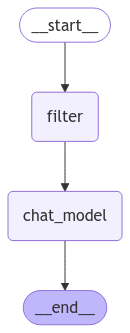

In [33]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState) -> MessagesState:
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState) -> MessagesState:
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great you're interested in ocean mammals! Whales are a huge group, but there's a whole fascinating world beyond them.  To suggest some others for your research, it would help to know what aspects of whales interest you.  Are you interested in:

* **Their biology?** (e.g., feeding strategies, social structures, migration patterns)
* **Their conservation status?** (e.g., endangered species, threats to their populations)
* **Their evolution?** (e.g., how they adapted to marine life)
* **Their cultural significance?** (e.g., in indigenous cultures)
* **Specific geographic regions?** (e.g., Arctic mammals, trop

#Filtering messages
If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: llm.invoke(messages[-1:]) to the model.

In [40]:
output['messages'][-1]

AIMessage(content='That\'s great you\'re interested in ocean mammals! Whales are a huge group, but there\'s a whole fascinating world beyond them.  To suggest some others for your research, it would help to know what aspects of whales interest you.  Are you interested in:\n\n* **Their biology?** (e.g., feeding strategies, social structures, migration patterns)\n* **Their conservation status?** (e.g., endangered species, threats to their populations)\n* **Their evolution?** (e.g., how they adapted to marine life)\n* **Their cultural significance?** (e.g., in indigenous cultures)\n* **Specific geographic regions?** (e.g., Arctic mammals, tropical mammals)\n\n\nOnce I know your area of interest, I can give you more specific recommendations.  However, here are some other groups of ocean mammals you should definitely consider:\n\n* **Dolphins and Porpoises:**  Incredibly diverse group with complex social structures and communication skills.  They range from the playful bottlenose dolphin to

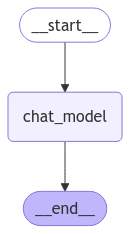

In [39]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [48]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [49]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great you're interested in ocean mammals! Whales are a huge group, but there's a whole fascinating world beyond them.  To suggest some others for your research, it would help to know what aspects of whales interest you.  Are you interested in:

* **Their biology?** (e.g., feeding strategies, social structures, migration patterns)
* **Their conservation status?** (e.g., endangered species, threats to their population

In [50]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great you're interested in ocean mammals! Whales are a huge group, but there's a whole fascinating world beyond them.  To suggest some others for your research, it would help to know what aspects of whales interest you.  Are you interested in:

* **Their biology?** (e.g., feeding strategies, social structures, migration patterns)
* **Their conservation status?** (e.g., endangered species, threats to their population

#Trim messages
Another approach is to trim messages, based upon a set number of tokens.

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the trim_messages below.

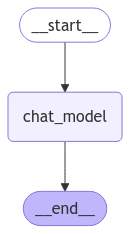

In [63]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatGoogleGenerativeAI(model="gemini-1.5-flash"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [64]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [65]:
# Invoke, using message trimming in the chat_model_node
messages_out_trim = graph.invoke({'messages': messages})

ERROR:grpc._plugin_wrapping:AuthMetadataPluginCallback "<google.auth.transport.grpc.AuthMetadataPlugin object at 0x79aaf4334c70>" raised exception!
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 128, in refresh
    self._retrieve_info(request)
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 101, in _retrieve_info
    info = _metadata.get_service_account_info(
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 323, in get_service_account_info
    return get(request, path, params={"recursive": "true"})
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 248, in get
    raise exceptions.TransportError(
google.auth.exceptions.TransportError: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Go

RetryError: Timeout of 60.0s exceeded, last exception: 503 Getting metadata from plugin failed with error: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Google Compute Engine metadata service. Status: 404 Response:\nb''", <google.auth.transport.requests._Response object at 0x79aaf423f070>)

In [56]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatGoogleGenerativeAI(model="gemini-1.5-flash"),
            allow_partial=False
        )

ERROR:grpc._plugin_wrapping:AuthMetadataPluginCallback "<google.auth.transport.grpc.AuthMetadataPlugin object at 0x79aaf4296410>" raised exception!
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 128, in refresh
    self._retrieve_info(request)
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 101, in _retrieve_info
    info = _metadata.get_service_account_info(
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 323, in get_service_account_info
    return get(request, path, params={"recursive": "true"})
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 248, in get
    raise exceptions.TransportError(
google.auth.exceptions.TransportError: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Go

KeyboardInterrupt: 